# Initial analysis of the Kaggle dataset

In [2]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import re
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import openai
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D

* Nodes = tweets
* Edges = similarity between tweets based on meaning (embedding cosine similarity)

### Load the dataset and generate the network

In [3]:
df = pd.read_csv("/Users/ame/02805_climate_conv/data/cleaned_twitter_embedded_data.csv")

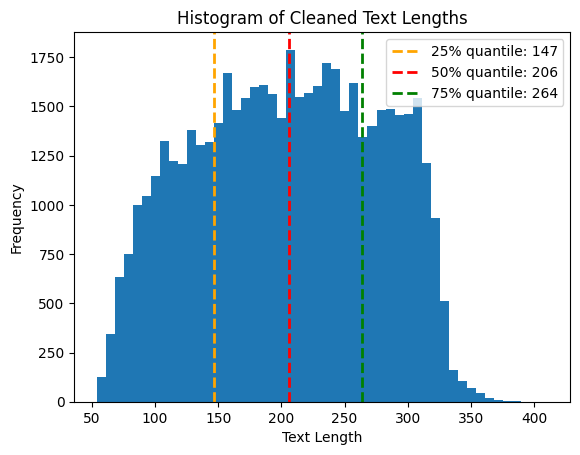

In [26]:
# make histogram of text lengths
plt.hist(df["clean_text"].str.len(), bins=50)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Histogram of Cleaned Text Lengths")

# Add 50% quantile line
quantile_50 = df["clean_text"].str.len().quantile(0.5)
quantile_25 = df["clean_text"].str.len().quantile(0.25)
quantile_75 = df["clean_text"].str.len().quantile(0.75)
# draw vertical lines for the quartiles separately (axvline expects a single x value)
plt.axvline(quantile_25, color='orange', linestyle='--', linewidth=2, label=f'25% quantile: {quantile_25:.0f}')
plt.axvline(quantile_50, color='red',    linestyle='--', linewidth=2, label=f'50% quantile: {quantile_50:.0f}')
plt.axvline(quantile_75, color='green',  linestyle='--', linewidth=2, label=f'75% quantile: {quantile_75:.0f}')
plt.legend()

plt.show()

In [32]:
# Print number of tweets longer than 100 characters
long_tweets = df[df["clean_text"].str.len() > quantile_25]
print(f"Number of tweets longer than {quantile_25} characters:", long_tweets.shape[0])

# Print total number of tweets
print("Total number of tweets:", df.shape[0])

Number of tweets longer than 147.0 characters: 38404
Total number of tweets: 51376


#### Section on how the similarity nework is defined (include files, embedding.py and make_init_network.py)

### Desciption of the network

In [37]:
# Load network from file to G
G = nx.read_gexf("/Users/ame/02805_climate_conv/networks/climate_tweet_network_embedded.gexf")
print("Graph loaded from file")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

# Print list of all node attributes
print("Node attributes:", list(next(iter(G.nodes(data=True)))[1].keys()))

Graph loaded from file
Nodes: 51376
Edges: 377198
Node attributes: ['tweetid', 'message', 'date', 'location', 'sentiment', 'clean_text', 'label']


In [65]:
# Make a sub graph only with nodes with more than quantile_25 characters
nodes_to_include = [n for n, attr in G.nodes(data=True) if len(attr.get("clean_text", "")) > quantile_25]
G_sub = G.subgraph(nodes_to_include).copy()
print("Subgraph with long tweets created")
print("Nodes in subgraph:", G_sub.number_of_nodes())
print("Edges in subgraph:", G_sub.number_of_edges())

# Save subgraph to file
nx.write_gexf(G_sub, "/Users/ame/02805_climate_conv/networks/climate_tweet_network_with_embeddings_sub.gexf")
print("Subgraph saved to file")

Subgraph with long tweets created
Nodes in subgraph: 38404
Edges in subgraph: 162726
Subgraph saved to file


In [53]:
# Giant connected component
gcc = max(nx.connected_components(G_sub), key=len)
G_gcc = G_sub.subgraph(gcc).copy()
print("Largest connected component created")
print("Nodes in LCC:", G_gcc.number_of_nodes())
print("Edges in LCC:", G_gcc.number_of_edges())

# Compute giant component share
gcc_share = G_gcc.number_of_nodes() / G_sub.number_of_nodes()
print("Giant component share:", gcc_share)

Largest connected component created
Nodes in LCC: 36532
Edges in LCC: 161797
Giant component share: 0.9512550775960837


In [54]:
# Print average degree
avg_degree = sum(dict(G_sub.degree()).values()) / G_sub.number_of_nodes()
print("Average degree:", avg_degree)

Average degree: 8.474429746901365


In [55]:
# Max and min degree
degrees = dict(G_sub.degree()).values()
print("Max degree:", max(degrees))
print("Min degree:", min(degrees))

# Print text of tweet with highest degree
max_deg_node = max(G_sub.degree, key=lambda x: x[1])[0]
print("Tweet with highest degree:", G.nodes[max_deg_node]["message"])

# Print text of tweet with lowest degree
min_deg_node = min(G_sub.degree, key=lambda x: x[1])[0]
print("Tweet with lowest degree:", G_sub.nodes[min_deg_node]["message"])

Max degree: 128
Min degree: 0
Tweet with highest degree: young leaders and climate advocates at the @un #climateaction summit. it is not possible to tackle #climatechange without the inclusive participation and action of youth. #actnow @unyouthenvoy – at united nations general assembly. date: 2019-09-23. location: florida, usa. sentiment: positive
Tweet with lowest degree: i can’t make it to the climate march in rva today, but i’m with everyone who can #climatestrike. date: 2019-09-20. location: california, usa. sentiment: positive


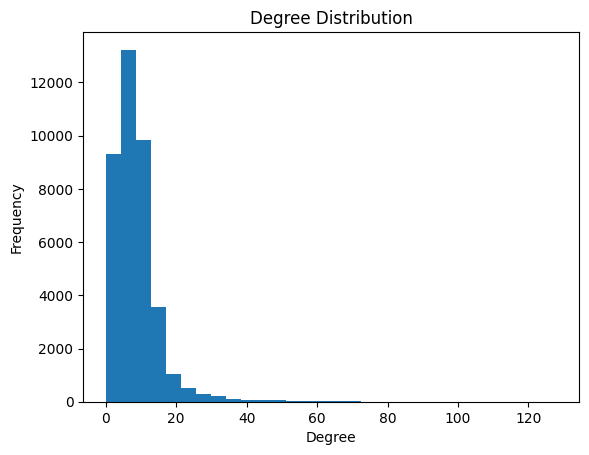

In [56]:
# Histogram of degree distribution
import matplotlib.pyplot as plt

plt.hist(degrees, bins=30)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

## Visualization of top-1000 nodes by degree

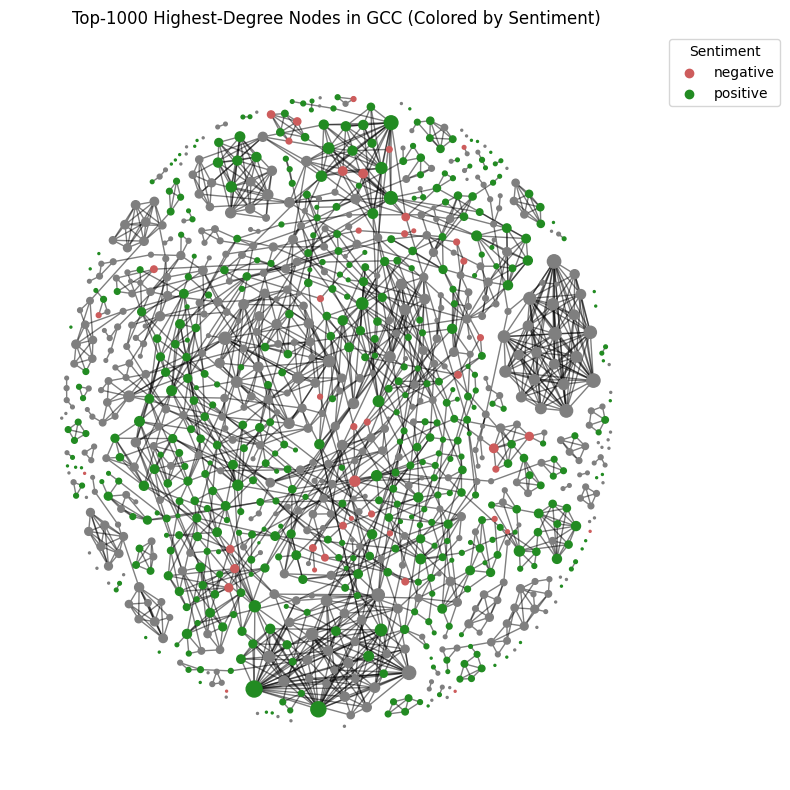

In [58]:
deg_gcc = dict(G_gcc.degree())

top_1000_nodes = sorted(deg_gcc, key=deg_gcc.get, reverse=True)[:1000]

# Induce the subgraph
G_top = G_gcc.subgraph(top_1000_nodes).copy()


# Sentiment colors
sentiment_colors = {
    "negative":  "indianred",
    "positive":  "forestgreen"
}

# Ensure nodes keep sentiment attribute
for n in G_top.nodes():
    G_top.nodes[n]["sentiment"] = G.nodes[n].get("sentiment")


# ForceAtlas2 layout
pos = nx.forceatlas2_layout(
    G_top,
    max_iter=500,
    gravity=0.8,
    scaling_ratio=2.0,
    seed=123,
    distributed_action=True,
    strong_gravity=True,
)


# Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Node sizes based on degree
node_sizes = [2 + G_top.degree(n) * 5 for n in G_top.nodes()]

nx.draw_networkx_edges(G_top, pos, ax=ax, alpha=0.5)

nx.draw_networkx_nodes(
    G_top,
    pos,
    ax=ax,
    node_size=node_sizes,
    alpha=1,
    node_color=[
        sentiment_colors.get(
            G_top.nodes[n].get("sentiment"),
            "#7f7f7f"  # default grey if missing
        )
        for n in G_top.nodes()
    ],
)

# Legend
for sentiment, color in sentiment_colors.items():
    ax.scatter([], [], c=color, label=sentiment)

ax.legend(
    title="Sentiment",
    loc="upper left",
    bbox_to_anchor=(1, 1),
)

ax.set_axis_off()
ax.set_title("Top-1000 Highest-Degree Nodes in GCC (Colored by Sentiment)")
plt.tight_layout()
plt.show()

## Visualization of network backbone

In [60]:
# Approximate edge betweenness
# Choose sample size k
k = 50

ebc = nx.edge_betweenness_centrality(G_sub, k=k, seed=42)

# Normalize betweenness to [1, 100]
vals = np.array(list(ebc.values()))
min_b, max_b = vals.min(), vals.max()

for u, v in G_sub.edges():
    w = ebc.get((u, v), 0.0)
    norm_w = 1 + 99 * (w - min_b) / (max_b - min_b) if max_b > min_b else 1
    G_sub[u][v]["weight"] = norm_w

W1 = G_sub.copy()

# Convert to DataFrame as before
W1_edges = [
    {"src": u, "trg": v, "nij": data["weight"]}
    for u, v, data in W1.edges(data=True)
]

table_W1 = pd.DataFrame(W1_edges)

In [61]:
import sys
from pathlib import Path

# Assuming this notebook is in 02805_climate_conv/notebooks/
project_root = Path.cwd().parent  # one level up
sys.path.append(str(project_root))

import help_files.backboning as backboning
import importlib
importlib.reload(backboning)

<module 'help_files.backboning' from '/Users/ame/02805_climate_conv/help_files/backboning.py'>

In [62]:
df_W1 = backboning.disparity_filter(table_W1, undirected=True)
backbone_W1 = backboning.thresholding(df_W1, threshold=0.8)
G_backbone_W1 = nx.from_pandas_edgelist(
    backbone_W1, source="src", target="trg", edge_attr="score"
)

Calculating DF score...


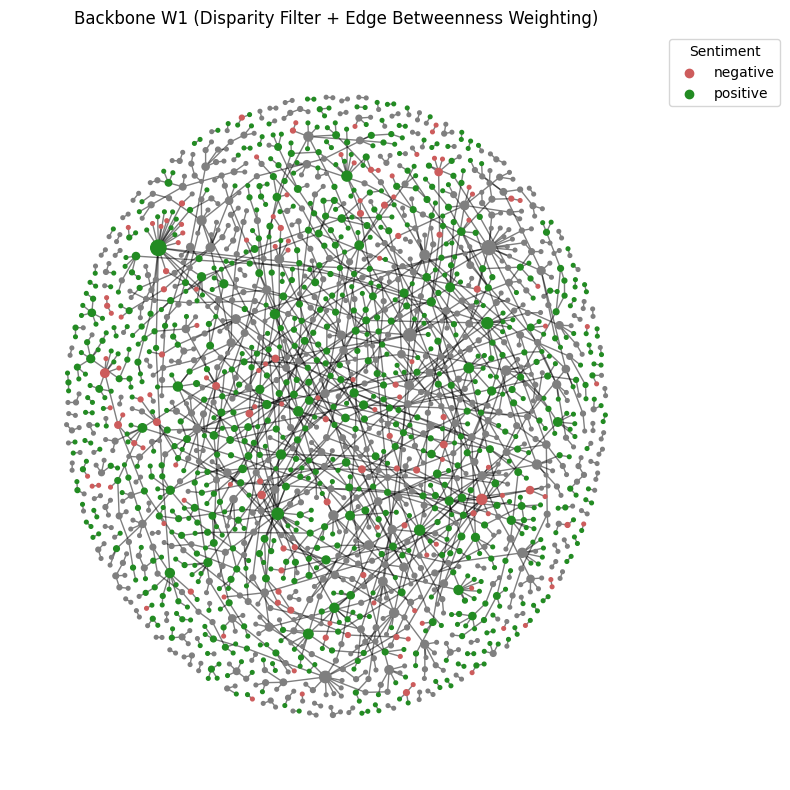

In [63]:
# Define colors
sentiment_colors = {
    "negative":      "indianred",  
    "positive":       "forestgreen"
}

# Make sure backbone nodes inherit sentiment from original G
for n in G_backbone_W1.nodes():
    if n in G.nodes:
        G_backbone_W1.nodes[n]["sentiment"] = G.nodes[n].get("sentiment")

# Layout ONLY for the backbone
pos_W1 = nx.forceatlas2_layout(
    G_backbone_W1,
    max_iter=500,
    gravity=0.8,
    scaling_ratio=2.0,
    seed=123,
    distributed_action=True,
    strong_gravity=True,
)

# Plot with sentiment-based coloring
fig, ax = plt.subplots(figsize=(8, 8))

# node sizes (degree-based)
node_sizes = [2 + G_backbone_W1.degree(n) * 5 for n in G_backbone_W1.nodes()]

nx.draw_networkx_edges(G_backbone_W1, pos_W1, ax=ax, alpha=0.5)

nodes = nx.draw_networkx_nodes(
    G_backbone_W1,
    pos_W1,
    ax=ax,
    node_size=node_sizes,
    alpha=1,
    node_color=[
        sentiment_colors.get(
            G_backbone_W1.nodes[n].get("sentiment"),
            "#7f7f7f"  # default grey if missing
        )
        for n in G_backbone_W1.nodes()
    ],
)

# Legend
for sentiment, color in sentiment_colors.items():
    ax.scatter([], [], c=color, label=sentiment)

ax.legend(
    title="Sentiment",
    loc="upper left",
    bbox_to_anchor=(1, 1),
)

ax.set_axis_off()
ax.set_title("Backbone W1 (Disparity Filter + Edge Betweenness Weighting)")
plt.tight_layout()
plt.show()

## Detect emotions

Note that it is based on G_sub (as the make file runs on that).

In [66]:
# Load emotion network
G = nx.read_gexf("/Users/ame/02805_climate_conv/networks/climate_tweet_network_embeddings_emotions.gexf")
print("Graph with emotions loaded from file")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

# Print list of attributes
print("Node attributes:", list(next(iter(G.nodes(data=True)))[1].keys()))

# Print number of nodes with each emotion attribute
emotion_counts = {}
for node, data in G.nodes(data=True):
    emotion = data.get("emotion", "none")
    emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
print("Emotion counts:", emotion_counts)

Graph with emotions loaded from file
Nodes: 38404
Edges: 162726
Node attributes: ['tweetid', 'message', 'date', 'location', 'sentiment', 'clean_text', 'emotion', 'emotion_probs', 'label']
Emotion counts: {'joy': 10298, 'fear': 14038, 'anger': 4650, 'disgust': 9418}


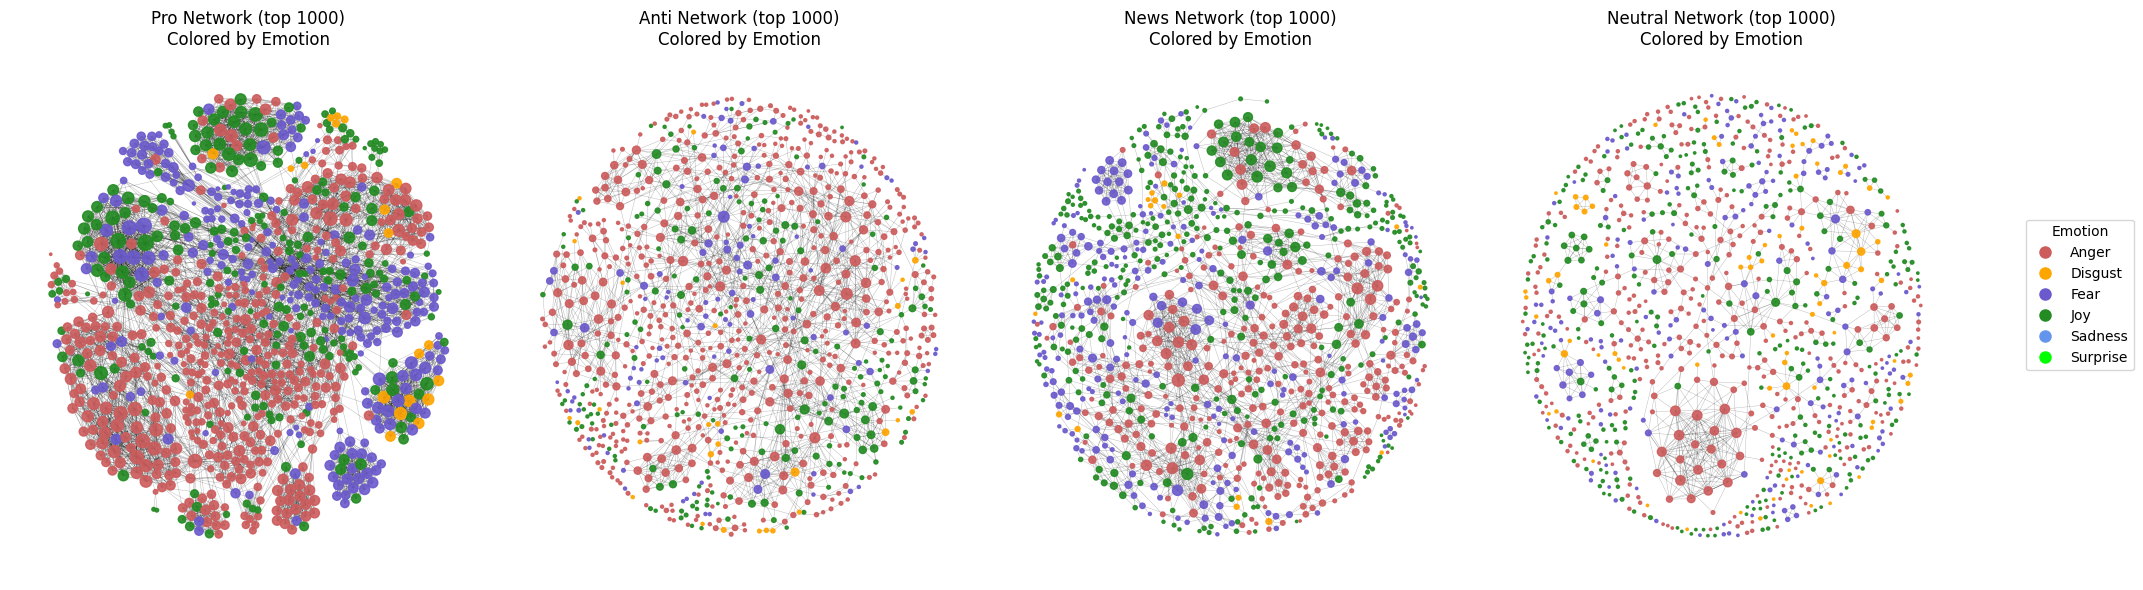

In [ ]:
# Build four subnetworks based on sentiment_label
sentiments = ["positive", "negative"]

subgraphs = {
    s: G.subgraph([
        n for n in G.nodes()
        if G.nodes[n].get("sentiment_label") == s and G.nodes[n].get("emotion", "none") != "none"
    ]).copy()
    for s in sentiments
}

# Emotion colors
emotion_colors = {
    "anger":    "indianred",
    "disgust":  "orange",
    "fear":     "slateblue",
    "joy":      "forestgreen",
    "sadness":  "cornflowerblue",
    "surprise": "lime",
}

# Plot the four networks next to each other
fig, axes = plt.subplots(1, 4, figsize=(22, 6))

for ax, sentiment in zip(axes, sentiments):
    SG_full = subgraphs[sentiment]

    if SG_full.number_of_nodes() == 0:
        ax.set_title(f"{sentiment.capitalize()} Network (no nodes)")
        ax.set_axis_off()
        continue

    # Top 1000 nodes by degree (within this sentiment group)
    deg_full = dict(SG_full.degree())
    top_nodes = sorted(deg_full, key=deg_full.get, reverse=True)[:1000]
    SG = SG_full.subgraph(top_nodes).copy()

    # Layout
    pos = nx.forceatlas2_layout(
        SG,
        seed=42,
        max_iter=1000,
        distributed_action=False,
        strong_gravity=True
    )

    # Node sizes
    deg = dict(SG.degree())
    node_sizes = [3 + 2 * deg[n] for n in SG.nodes()]

    # Node colors based on EMOTION
    node_colors = [
        emotion_colors.get(G.nodes[n].get("emotion"), "#999999")
        for n in SG.nodes()
    ]

    # Draw network
    nx.draw_networkx_edges(SG, pos, ax=ax, width=0.3, alpha=0.3)
    nx.draw_networkx_nodes(
        SG,
        pos,
        ax=ax,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.9
    )

    ax.set_title(f"{sentiment.capitalize()} Network (top 1000)\nColored by Emotion")
    ax.set_axis_off()

# Add one shared legend on the right
legend_handles = [
    Line2D(
        [0], [0],
        marker="o",
        linestyle="",
        markersize=8,
        color=color,
        label=emotion.capitalize()
    )
    for emotion, color in emotion_colors.items()
]

# Make room on the right for the legend
plt.tight_layout(rect=[0, 0, 0.9, 1])

fig.legend(
    handles=legend_handles,
    title="Emotion",
    loc="center left",
    bbox_to_anchor=(0.92, 0.5)
)

plt.show()


In [66]:
# For each subgraph print the text and emotion of top 5 nodes by degree where emotion is not 'none'
for sentiment, SG in subgraphs.items():
    deg = dict(SG.degree())
    top_nodes = sorted(deg, key=deg.get, reverse=True)[:5]
    print(f"Top 5 nodes in {sentiment} sentiment:")
    for n in top_nodes:
        emotion = G.nodes[n].get("emotion", "none")
        message = G.nodes[n].get("message", "")
        print(f" - Emotion: {emotion}, Message: {message}")
    print()

Top 5 nodes in pro sentiment:
 - Emotion: anger, Message: RT @ShawnFatfield: I refuse to believe that people don't believe in climate change...Which I guess would make me a 'Climate Change Denier Dâ¦
 - Emotion: anger, Message: On climate change, Scott Pruitt causes an uproar - and contradicts the EPAâs own website https://t.co/itzqwiFh0A
Protect our planet..
 - Emotion: anger, Message: RT @danichrissette: Can y'all believe donald trump actually believes climate change isn't real??? and there's people that agree with him???ÃÂ¢Ã¢âÂ¬ÃÂ¦
 - Emotion: joy, Message: RT @peta2: Meat production ï¿½ï¿½ is a leading cause of âï¸ climate change ï¿½ï¿½ water waste ï¿½ï¿½ &amp; deforestation ï¿½ï¿½ï¿½ï¿½ Stop #ClimateChange: #GoVegan
 - Emotion: anger, Message: RT @SenSanders: We have a president-elect who doesnÃÂ¢Ã¢âÂ¬Ã¢âÂ¢t believe in climate change. ThatÃÂ¢Ã¢âÂ¬Ã¢âÂ¢s frightening for this country and the world.

Top 5 nodes in anti sentiment:
 - Emotion: anger, Message: RT @S

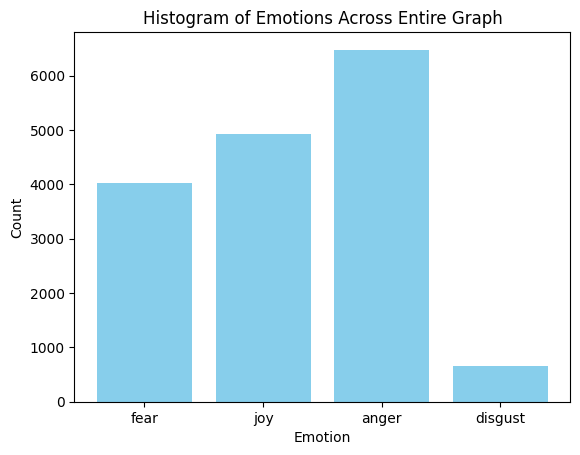

In [67]:
# Make a histogram of emotions across the entire graph ignoring nodes without emotion attribute
emotion_counts = {}
for n in G.nodes():
    emotion = G.nodes[n].get("emotion")
    if emotion:
        emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
# Plot histogram
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Histogram of Emotions Across Entire Graph")
plt.show()

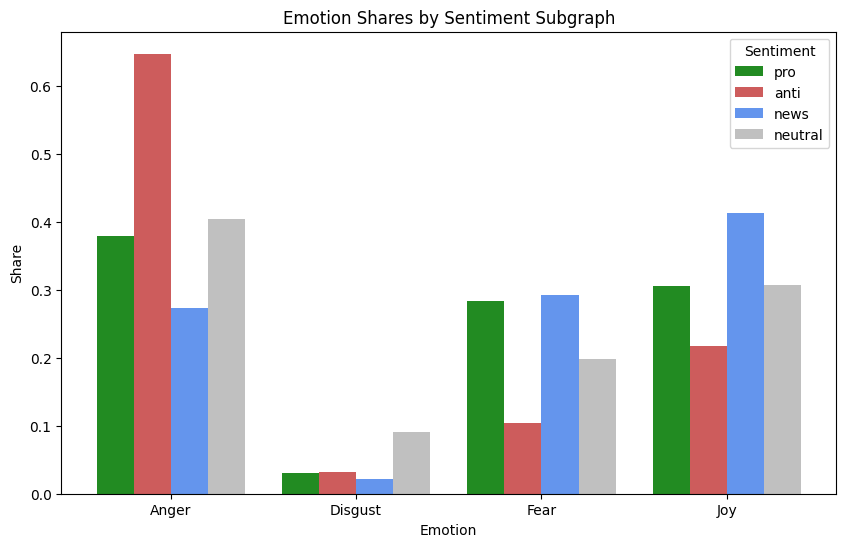

In [73]:
# Compute shares of each emotion for each sentiment subgraph and plot them together
emotion_shares = {s: {} for s in sentiments}
for sentiment, SG in subgraphs.items():
    total_nodes = SG.number_of_nodes()
    if total_nodes == 0:
        continue
    emotion_counts = {}
    for n in SG.nodes():
        emotion = G.nodes[n].get("emotion")
        if emotion and emotion not in ["sadness", "surprise"]:
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
    for emotion, count in emotion_counts.items():
        emotion_shares[sentiment][emotion] = count / total_nodes

# Plot grouped bar chart
labels = [e for e in emotion_colors.keys() if e not in ["sadness", "surprise"]]
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))
for i, sentiment in enumerate(sentiments):
    shares = [emotion_shares[sentiment].get(emotion, 0) for emotion in labels]
    ax.bar(
        x + i * width,
        shares,
        width,
        label=sentiment,
        color=sentiment_colors[sentiment]
    )
ax.set_xlabel("Emotion")
ax.set_ylabel("Share")
ax.set_title("Emotion Shares by Sentiment Subgraph")
ax.set_xticks(x + width * (len(sentiments) - 1) / 2)
ax.set_xticklabels([e.capitalize() for e in labels])
ax.legend(title="Sentiment")
plt.show()

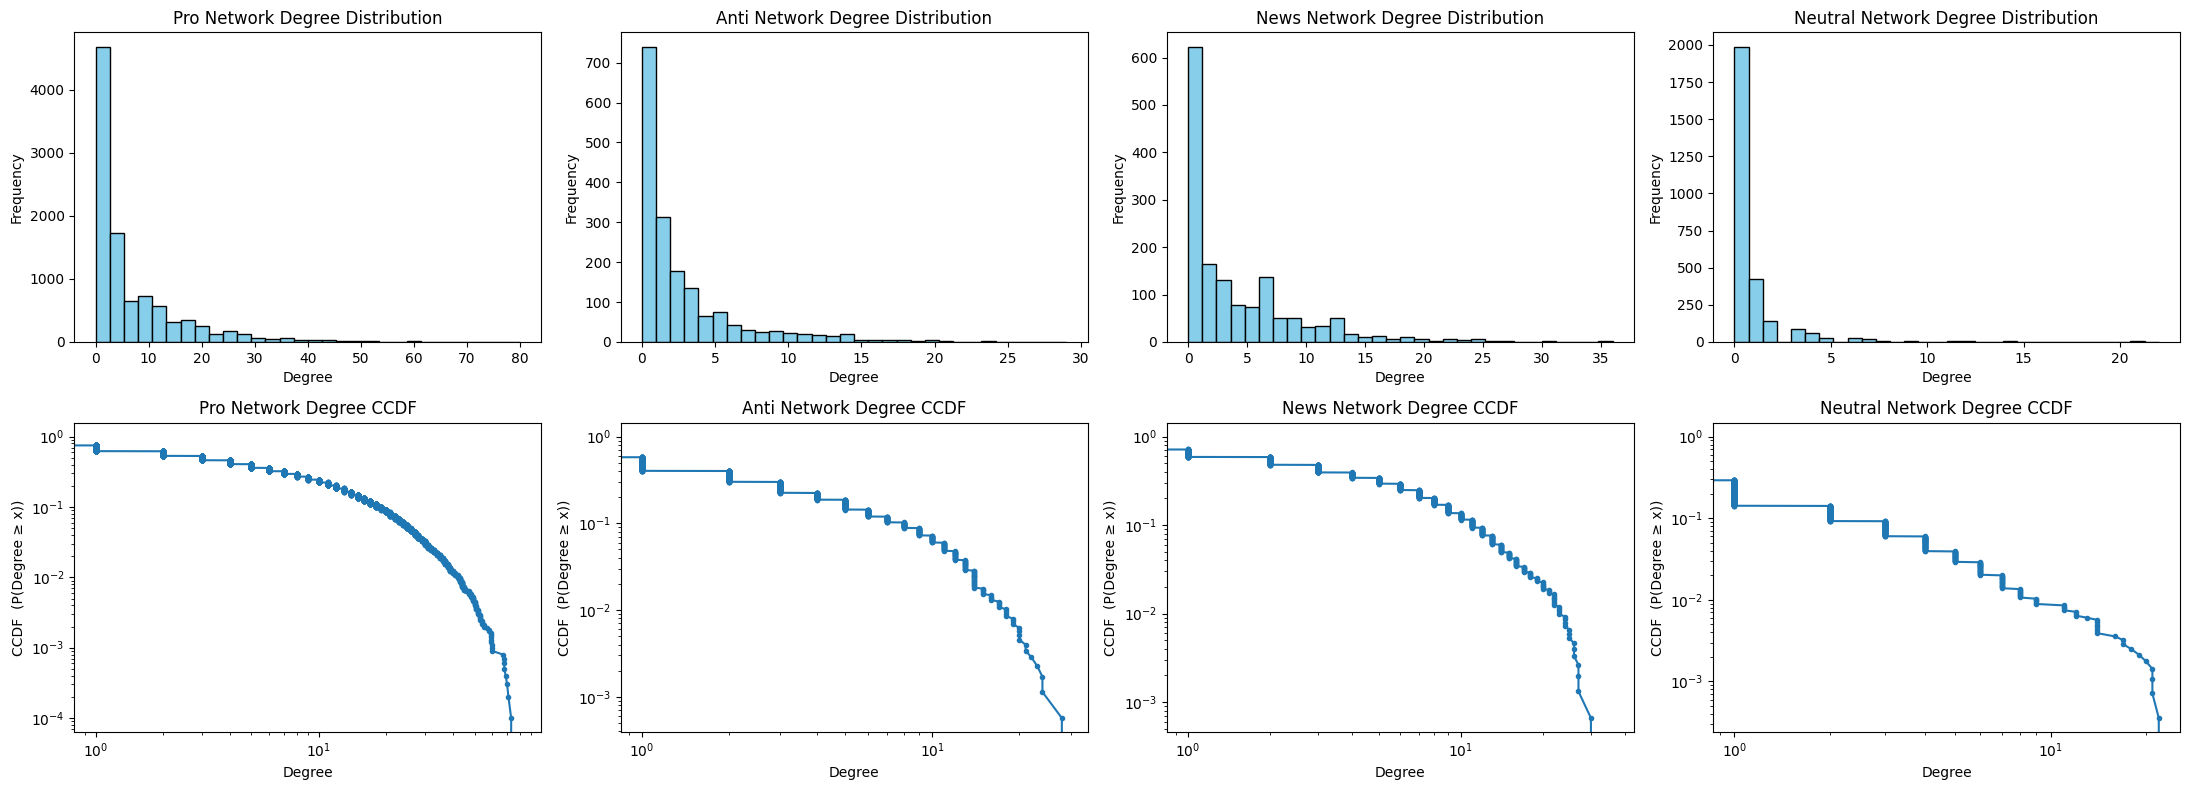

In [ ]:
def compute_ccdf(data):
    data = np.array(data)
    data = np.sort(data)
    n = len(data)
    # CCDF: P(X ≥ x)
    ccdf = 1.0 - np.arange(1, n + 1) / n
    return data, ccdf

# Plot: top row = histograms, bottom row = CCDFs
fig, axes = plt.subplots(2, 4, figsize=(22, 8))

for col, sentiment in enumerate(sentiments):
    SG = subgraphs[sentiment]

    if SG.number_of_nodes() == 0:
        axes[0, col].set_title(f"{sentiment.capitalize()} Network (no nodes)")
        axes[0, col].set_axis_off()
        axes[1, col].set_axis_off()
        continue

    degrees = [d for _, d in SG.degree()]

    # Top row: histogram
    ax_hist = axes[0, col]
    ax_hist.hist(degrees, bins=30, color="skyblue", edgecolor="black")
    ax_hist.set_title(f"{sentiment.capitalize()} Network Degree Distribution")
    ax_hist.set_xlabel("Degree")
    ax_hist.set_ylabel("Frequency")

    # Bottom row: CCDF
    ax_ccdf = axes[1, col]
    x, y = compute_ccdf(degrees)
    ax_ccdf.plot(x, y, marker=".", linestyle="-")
    ax_ccdf.set_xlabel("Degree")
    ax_ccdf.set_ylabel("CCDF  (P(Degree ≥ x))")
    ax_ccdf.set_title(f"{sentiment.capitalize()} Network Degree CCDF")

    # Use log scale
    ax_ccdf.set_xscale("log")
    ax_ccdf.set_yscale("log")

plt.tight_layout()
plt.show()

### Communities

Modularity of sentiment-partition

In [80]:
import networkx as nx
from collections import defaultdict, Counter
from networkx.algorithms.community.quality import modularity

# Only use nodes with char length > 100 and valid emotion
valid_emotions = {"anger", "disgust", "fear", "joy", "sadness", "surprise"}

nodes_with_emotion = [
    n for n in G.nodes()
    if G.nodes[n].get("emotion") in valid_emotions
]

G_base = G.subgraph(nodes_with_emotion).copy()

print("=== BASE GRAPH (len(clean_text) > 100, has emotion) ===")
print(f"Nodes: {G_base.number_of_nodes()}")
print(f"Edges: {G_base.number_of_edges()}")

valid_sentiments = {"pro", "anti", "news", "neutral"}

nodes_with_sentiment = [
    n for n in G_base.nodes()
    if G_base.nodes[n].get("sentiment_label") in valid_sentiments
]

G_sent = G_base.subgraph(nodes_with_sentiment).copy()

print("\n=== SENTIMENT PARTITION (on base graph) ===")
print(f"Nodes with valid sentiment: {G_sent.number_of_nodes()}")
print(f"Edges: {G_sent.number_of_edges()}")

# Partition: node -> sentiment
sent_partition = {
    n: G_sent.nodes[n]["sentiment_label"]
    for n in G_sent.nodes()
}

# Count sizes
sent_counts = Counter(sent_partition.values())
print("\nSentiment sizes:")
for s, c in sent_counts.items():
    print(f"{s}: {c}")

# Communities list
sent_to_nodes = defaultdict(set)
for n, s in sent_partition.items():
    sent_to_nodes[s].add(n)
sent_communities = list(sent_to_nodes.values())

# Modularity
Q_sent = modularity(G_sent, sent_communities)
print(f"\nModularity (sentiment): Q = {Q_sent:.4f}")

G_emo = G_base  # already only has nodes with valid emotions

print("\n=== EMOTION PARTITION (on base graph) ===")
print(f"Nodes with emotion: {G_emo.number_of_nodes()}")
print(f"Edges: {G_emo.number_of_edges()}")

# Partition: node -> emotion
emo_partition = {
    n: G_emo.nodes[n]["emotion"]
    for n in G_emo.nodes()
}

# Count sizes
emo_counts = Counter(emo_partition.values())
print("\nEmotion sizes:")
for e, c in emo_counts.items():
    print(f"{e}: {c}")

# Communities list
emo_to_nodes = defaultdict(set)
for n, e in emo_partition.items():
    emo_to_nodes[e].add(n)
emo_communities = list(emo_to_nodes.values())

# Modularity
Q_emo = modularity(G_emo, emo_communities)
print(f"\nModularity (emotion): Q = {Q_emo:.4f}")

=== BASE GRAPH (len(clean_text) > 100, has emotion) ===
Nodes: 16079
Edges: 60480

=== SENTIMENT PARTITION (on base graph) ===
Nodes with valid sentiment: 16079
Edges: 60480

Sentiment sizes:
pro: 9997
news: 1513
neutral: 2808
anti: 1761

Modularity (sentiment): Q = 0.1410

=== EMOTION PARTITION (on base graph) ===
Nodes with emotion: 16079
Edges: 60480

Emotion sizes:
fear: 4020
joy: 4928
disgust: 654
anger: 6477

Modularity (emotion): Q = 0.2289


Louvain communities

In [81]:
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity

# Louvain communities on the SAME base network as emotions/sentiments
communities = louvain_communities(G_base, seed=42)

# Modularity of the Louvain partition
Q = modularity(G_base, communities)
print(f"Louvain: found {len(communities)} communities")
print(f"Modularity Q = {Q:.4f}")

Louvain: found 4442 communities
Modularity Q = 0.7931


In [82]:
# Print number of nodes for the 10 largest Louvain communities
community_sizes = sorted([len(c) for c in communities], reverse=True)
print("\nSizes of the 10 largest Louvain communities:")
for i, size in enumerate(community_sizes[:10], start=1):
    print(f"Community {i}: {size} nodes")


Sizes of the 10 largest Louvain communities:
Community 1: 1332 nodes
Community 2: 1258 nodes
Community 3: 1047 nodes
Community 4: 599 nodes
Community 5: 524 nodes
Community 6: 507 nodes
Community 7: 489 nodes
Community 8: 487 nodes
Community 9: 437 nodes
Community 10: 433 nodes


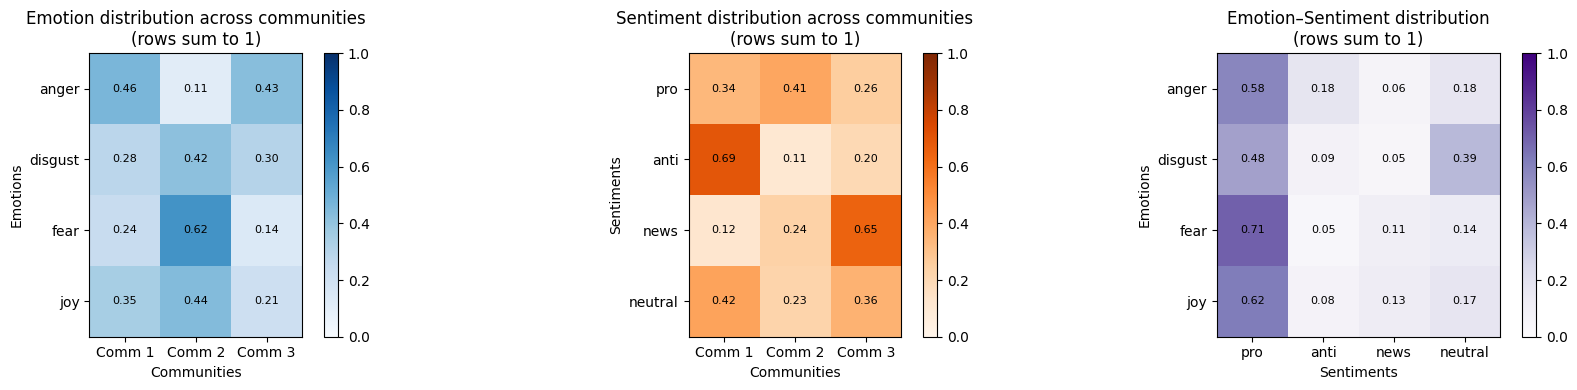

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from networkx.algorithms.community import louvain_communities

# Louvain on the base graph (G_base)
communities = louvain_communities(G_base, seed=42)
communities_sorted = sorted(communities, key=len, reverse=True)
C1, C2, C3 = communities_sorted[:3]
top3 = [C1, C2, C3]
community_labels = ["Comm 1", "Comm 2", "Comm 3"]

# Categories
valid_emotions   = ["anger", "disgust", "fear", "joy"]
valid_sentiments = ["pro", "anti", "news", "neutral"]

# Counting helpers
def count_for_communities(categories, attr_name):
    """
    Returns matrix (len(categories) x 3)
    rows = categories (emotions/sentiments)
    cols = communities
    """
    mat = np.zeros((len(categories), len(top3)), dtype=float)
    for j, C in enumerate(top3):  # communities
        counts = Counter(G_base.nodes[n].get(attr_name) for n in C)
        for i, cat in enumerate(categories):
            mat[i, j] = counts.get(cat, 0)
    return mat

def count_emotion_sentiment(emotions, sentiments):
    """
    Returns matrix (len(emotions) x len(sentiments)):
    rows = emotions
    cols = sentiments
    """
    mat = np.zeros((len(emotions), len(sentiments)), dtype=float)
    for n in G_base.nodes():
        e = G_base.nodes[n].get("emotion")
        s = G_base.nodes[n].get("sentiment_label")
        if e in emotions and s in sentiments:
            mat[emotions.index(e), sentiments.index(s)] += 1
    return mat

def row_normalize(mat):
    row_sums = mat.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    return mat / row_sums

# Build matrices
emotion_counts     = count_for_communities(valid_emotions,   "emotion")
sentiment_counts   = count_for_communities(valid_sentiments, "sentiment_label")
emotion_sentiment  = count_emotion_sentiment(valid_emotions, valid_sentiments)

# Row-normalized
emotion_frac        = row_normalize(emotion_counts)
sentiment_frac      = row_normalize(sentiment_counts)
emotion_sent_frac   = row_normalize(emotion_sentiment)

# Plot all three heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot 1: Emotion × Community
ax = axes[0]
im1 = ax.imshow(emotion_frac, cmap="Blues", vmin=0, vmax=1)
ax.set_xticks(range(len(community_labels)))
ax.set_xticklabels(community_labels)
ax.set_yticks(range(len(valid_emotions)))
ax.set_yticklabels(valid_emotions)
ax.set_xlabel("Communities")
ax.set_ylabel("Emotions")
ax.set_title("Emotion distribution across communities\n(rows sum to 1)")
for i in range(len(valid_emotions)):
    for j in range(len(community_labels)):
        ax.text(j, i, f"{emotion_frac[i, j]:.2f}", ha="center", va="center", fontsize=8)
fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

# Plot 2: Sentiment × Community
ax = axes[1]
im2 = ax.imshow(sentiment_frac, cmap="Oranges", vmin=0, vmax=1)
ax.set_xticks(range(len(community_labels)))
ax.set_xticklabels(community_labels)
ax.set_yticks(range(len(valid_sentiments)))
ax.set_yticklabels(valid_sentiments)
ax.set_xlabel("Communities")
ax.set_ylabel("Sentiments")
ax.set_title("Sentiment distribution across communities\n(rows sum to 1)")
for i in range(len(valid_sentiments)):
    for j in range(len(community_labels)):
        ax.text(j, i, f"{sentiment_frac[i, j]:.2f}", ha="center", va="center", fontsize=8)
fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

# Plot 3: Emotion × Sentiment
ax = axes[2]
im3 = ax.imshow(emotion_sent_frac, cmap="Purples", vmin=0, vmax=1)
ax.set_xticks(range(len(valid_sentiments)))
ax.set_xticklabels(valid_sentiments, rotation=0)
ax.set_yticks(range(len(valid_emotions)))
ax.set_yticklabels(valid_emotions)
ax.set_xlabel("Sentiments")
ax.set_ylabel("Emotions")
ax.set_title("Emotion–Sentiment distribution\n(rows sum to 1)")
for i in range(len(valid_emotions)):
    for j in range(len(valid_sentiments)):
        ax.text(j, i, f"{emotion_sent_frac[i, j]:.2f}", ha="center", va="center", fontsize=8)
fig.colorbar(im3, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Wording and messages

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Collect ALL clean_text from G
texts = []

for n in G.nodes():
    t = G.nodes[n].get("clean_text", "")
    if isinstance(t, str) and t.strip():
        texts.append(t)

print("Number of texts:", len(texts))

# TF-IDF with 4-GRAMS ONLY
vectorizer = TfidfVectorizer(
    ngram_range=(4, 4),        
    min_df=5,                  # ignore bigrams that appear in <5 docs
    max_df=0.8,                # ignore very common bigrams
    stop_words="english"       # remove English stopwords
)

tfidf = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()

# Extract top N overall
N = 40

# Sum TF-IDF scores across all documents
scores = tfidf.sum(axis=0).A1
top_indices = scores.argsort()[::-1][:N]

print("\nTop TF-IDF bigrams (global):\n")
for idx in top_indices:
    print(f"{feature_names[idx]:<40} {scores[idx]:.4f}")

Number of texts: 37944

Top TF-IDF bigrams (global):

doesn believe climate change             120.8498
don believe climate change               117.9354
climate change isn real                  115.1282
global warming climate change            114.5249
global warming isn real                  94.5680
climate change global warming            88.1216
don believe global warming               75.4505
human caused climate change              57.4687
doesn believe global warming             56.0290
paris agreement climate change           55.0000
help fight climate change                52.0354
paris climate change agreement           49.6873
donald trump climate change              43.9101
thinks climate change hoax               41.1106
global warming doesn exist               40.7526
climate change chinese hoax              39.8623
climate change national security         39.4873
paris climate change deal                32.9245
climate change doesn exist               32.7343
time talk c

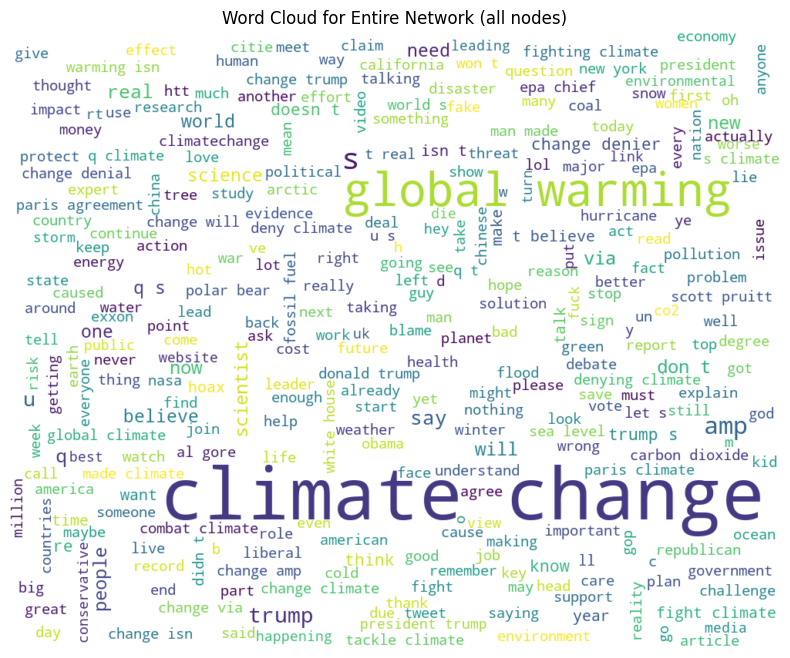

In [104]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Collect ALL text from G_base
all_texts = []

for n in G.nodes():
    text = G.nodes[n].get("clean_text", "")
    if isinstance(text, str) and text.strip():
        all_texts.append(text)

corpus = " ".join(all_texts)

wc = WordCloud(
    width=1000,
    height=800,
    background_color="white",
    max_words=300
).generate(corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Entire Network (all nodes)")
plt.show()

Top nodes by degree: Core messages

Top node by betweenness: Brigdes beween debates (sentiments, political, scientific, language)